#Preprocessing

In [ ]:
import pandas as pd
penguins_data = pd.read_csv('/content/penguins (1).csv')
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

 # Impute missing numerical values with the median
penguins_data_filled = penguins_data.copy()
numerical_columns = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

for column in numerical_columns:
    penguins_data_filled[column].fillna(penguins_data_filled[column].median(), inplace=True)

# Check if the numerical missing values have been filled
penguins_data_filled.isnull().sum()


# Impute missing numerical values with the median
numerical_columns = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
for column in numerical_columns:
    penguins_data[column].fillna(penguins_data[column].median(), inplace=True)

# Encode categorical variables and save the encoders for later use
label_encoders = {}
for column in ['species', 'island']:
    le = LabelEncoder()
    penguins_data[column] = le.fit_transform(penguins_data[column])
    label_encoders[column] = le

# Split data into known and unknown sex
known_sex = penguins_data[penguins_data['sex'].notnull()]
unknown_sex = penguins_data[penguins_data['sex'].isnull()]

# Prepare features and target for known_sex
features = ['species', 'island', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
X_known = known_sex[features]
y_known = known_sex['sex']

# Encode the target variable 'sex'
le_sex = LabelEncoder()
y_known_encoded = le_sex.fit_transform(y_known)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_known, y_known_encoded, test_size=0.3, random_state=42)

# Train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
print("Accuracy on test set:", accuracy_score(y_test, y_pred))
print("Classification Report:", classification_report(y_test, y_pred, target_names=le_sex.classes_))

# Predict the missing 'sex' values using the trained model
X_unknown = unknown_sex[features]
predicted_sex_encoded = rf_model.predict(X_unknown)
predicted_sex = le_sex.inverse_transform(predicted_sex_encoded)

# Fill in the missing 'sex' values in the original dataframe
penguins_data.loc[penguins_data['sex'].isnull(), 'sex'] = predicted_sex

# Decode the 'species' and 'island' columns back to their original string values for better interpretation
penguins_data['species'] = label_encoders['species'].inverse_transform(penguins_data['species'])
penguins_data['island'] = label_encoders['island'].inverse_transform(penguins_data['island'])

# Display a sample of the updated dataset
penguins_data.head()
penguins_data.to_csv('penguins_data', index= False)





Accuracy on test set: 0.9
Classification Report:               precision    recall  f1-score   support

      female       0.92      0.88      0.90        51
        male       0.88      0.92      0.90        49

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100



Outliers for bill_length_mm by species:
    species  bill_length_mm
185  Gentoo            59.6


Outliers for bill_depth_mm by species:
   species  bill_depth_mm
19  Adelie           21.5


Outliers for flipper_length_mm by species:
    species  flipper_length_mm
28   Adelie              172.0
129  Adelie              210.0
271  Gentoo              197.0


Outliers for body_mass_g by species:
       species  body_mass_g
313  Chinstrap       4800.0
314  Chinstrap       2700.0


General statistics of the dataset for comparison, by species:
          bill_length_mm                                                    \
                   count       mean       std   min     25%    50%     75%   
species                                                                      
Adelie             152.0  38.828618  2.693957  32.1  36.775  38.80  40.800   
Chinstrap           68.0  48.833824  3.339256  40.9  46.350  49.55  51.075   
Gentoo             124.0  47.480242  3.081540  40.9  45.275  47.2

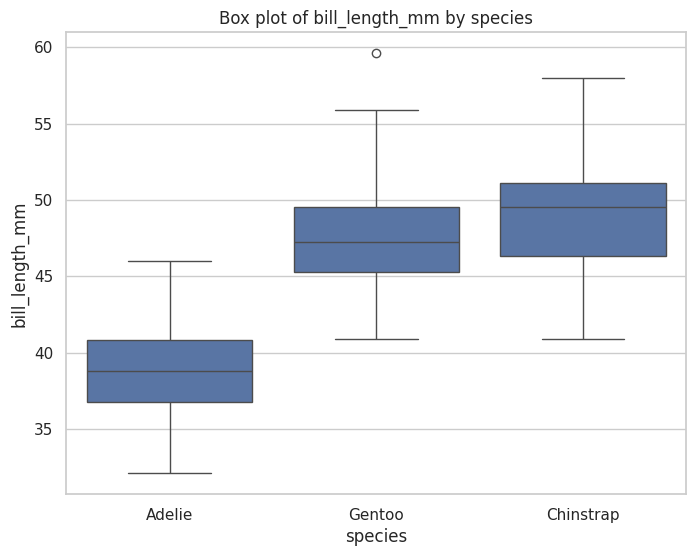

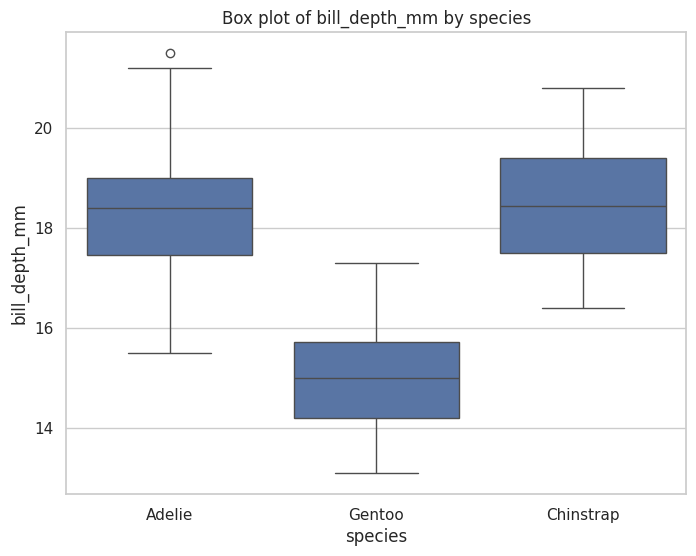

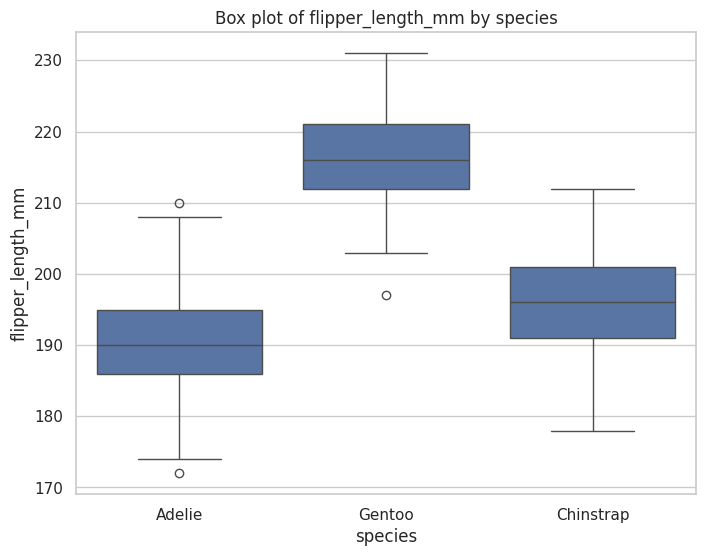

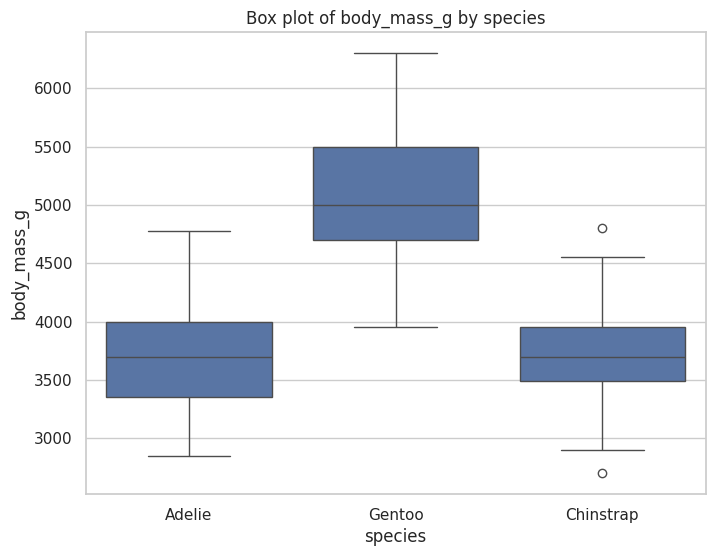

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Function to calculate outliers within each species for a given column
def calculate_outliers_by_species(df, group_column, target_column):
    outliers = pd.DataFrame()
    for _, group in df.groupby(group_column):
        Q1 = group[target_column].quantile(0.25)
        Q3 = group[target_column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        group_outliers = group[(group[target_column] < lower_bound) | (group[target_column] > upper_bound)]
        outliers = pd.concat([outliers, group_outliers], axis=0)
    return outliers

# Identifying outliers for each numerical feature within each species
numerical_features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
species_column = 'species'
outliers_dict_by_species = {}

for feature in numerical_features:
    outliers_dict_by_species[feature] = calculate_outliers_by_species(penguins_data, species_column, feature)

# Display the outliers for each feature by species
for feature, outliers in outliers_dict_by_species.items():
    print(f"Outliers for {feature} by species:")
    if not outliers.empty:
        print(outliers[[species_column, feature]])
    else:
        print("No outliers found.")
    print("\n")

# General statistics for context, grouped by species
print("General statistics of the dataset for comparison, by species:")
print(penguins_data.groupby(species_column)[numerical_features].describe())

# Plotting box plots for visual inspection, by species
sns.set(style="whitegrid")
for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=species_column, y=feature, data=penguins_data)
    plt.title(f'Box plot of {feature} by species')
    plt.show()


In [ ]:
peng_dropped = penguins_data.drop(['rowid', 'year'], axis=1)


sns.pairplot(peng_dropped, hue="species")

plt.savefig('pairplot.pdf')

In [ ]:

# Define features and target
X = penguins_data[['island', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']]
y = penguins_data['species']  # Target variable

# Encode 'sex' column as it is categorical
le_sex = LabelEncoder()
X['sex'] = le_sex.fit_transform(X['sex'])
X['island'] = le_sex.fit_transform(X['island'])
# Encoding the 'species' column as it is categorical
species_encoder = LabelEncoder()
y = species_encoder.fit_transform(y)  # This replaces your original 'y' with the encoded labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=18)




<ipython-input-5-4a16ec908a6e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['sex'] = le_sex.fit_transform(X['sex'])
<ipython-input-5-4a16ec908a6e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['island'] = le_sex.fit_transform(X['island'])


#Scaling

In [ ]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Apply the same transformation to the test data
X_test_scaled = scaler.transform(X_test)

#Baseline

In [ ]:


# Create the dummy classifier to always predict the majority class
dummy_clf = DummyClassifier(strategy='most_frequent')

# Fit the dummy classifier on the training data
dummy_clf.fit(X_train_scaled, y_train)

# Predict the labels for the test data
y_pred_dummy = dummy_clf.predict(X_test_scaled)

# Evaluate the accuracy of the dummy classifier
dummy_accuracy = accuracy_score(y_test, y_pred_dummy)
print(f"Baseline Accuracy (Dummy Classifier): {dummy_accuracy:.2f}")


Baseline Accuracy (Dummy Classifier): 0.43


# Naive Bayes

In [ ]:
# Correcting the issue with missing imports
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
# Retrain the model and predict
gnb.fit(X_train, y_train)  # Training the model
y_pred = gnb.predict(X_test)  # Predicting the Test set results

# Recalculating the metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report_df = pd.DataFrame(classification_report(y_test, y_pred, target_names=species_encoder.classes_, output_dict=True)).transpose()
report_df




,precision,recall,f1-score,support
Adelie,0.977273,0.955556,0.966292,45.000000
Chinstrap,0.900000,0.947368,0.923077,19.000000
Gentoo,1.000000,1.000000,1.000000,40.000000
accuracy,0.971154,0.971154,0.971154,0.971154
macro avg,0.959091,0.967641,0.963123,104.000000
weighted avg,0.971897,0.971154,0.971362,104.000000


# Logistic regression

In [ ]:


# Define the model and hyperparameters
log_reg = LogisticRegression(max_iter=10000, random_state=42, solver='saga', multi_class='multinomial', class_weight='balanced')
parameters_lr = {'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l2', 'l1']}

# Set up the grid search with balanced class weights
grid_lr_balanced = GridSearchCV(log_reg, parameters_lr, cv=5, scoring='accuracy')


grid_lr_balanced.fit(X_train_scaled, y_train)

# Evaluate the model on scaled test data
best_lr_balanced_scaled = grid_lr_balanced.best_estimator_
lr_predictions_balanced_scaled = best_lr_balanced_scaled.predict(X_test_scaled)

# Print out the performance metrics
print("Multinomial and Scaled Logistic Regression Performance:")
print("Best Parameters:", grid_lr_balanced.best_params_)
print("Accuracy:", accuracy_score(y_test, lr_predictions_balanced_scaled))
print(classification_report(y_test, lr_predictions_balanced_scaled))
report_df_lr = pd.DataFrame(classification_report(y_test, lr_predictions_balanced_scaled, target_names=species_encoder.classes_, output_dict=True)).transpose()
report_df_lr

Multinomial and Scaled Logistic Regression Performance:
Best Parameters: {'C': 1, 'penalty': 'l2'}
Accuracy: 0.9903846153846154
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        45
           1       1.00      0.95      0.97        19
           2       1.00      1.00      1.00        40

    accuracy                           0.99       104
   macro avg       0.99      0.98      0.99       104
weighted avg       0.99      0.99      0.99       104



,precision,recall,f1-score,support
Adelie,0.978261,1.000000,0.989011,45.000000
Chinstrap,1.000000,0.947368,0.972973,19.000000
Gentoo,1.000000,1.000000,1.000000,40.000000
accuracy,0.990385,0.990385,0.990385,0.990385
macro avg,0.992754,0.982456,0.987328,104.000000
weighted avg,0.990594,0.990385,0.990308,104.000000


In [ ]:
import numpy as np
import pandas as pd


# Identifying where each model makes incorrect predictions
nb_errors = y_pred != y_test
mlr_errors = lr_predictions_balanced_scaled != y_test

# Identifying indices where both models make mistakes
both_errors = nb_errors & mlr_errors

# Identifying indices where only one model makes a mistake
only_nb_errors = nb_errors & ~mlr_errors
only_mlr_errors = mlr_errors & ~nb_errors

# Summary
print(f"Total test samples: {len(y_test)}")
print(f"Mistakes by both models: {np.sum(both_errors)}")
print(f"Mistakes only by Naive Bayes: {np.sum(only_nb_errors)}")
print(f"Mistakes only by Multinomial Logistic Regression: {np.sum(only_mlr_errors)}")

# If you want to see the specific instances where errors occurred:
# Just change 'data' to your original DataFrame containing all features and labels
error_analysis = pd.DataFrame({
    'True Label': y_test,
    'Naive Bayes Prediction': y_pred,
    'MLR Prediction': lr_predictions_balanced_scaled,
    'Both Wrong': both_errors,
    'Only NB Wrong': only_nb_errors,
    'Only MLR Wrong': only_mlr_errors
})

# Filter to show examples where at least one model is wrong
error_analysis_filtered = error_analysis[error_analysis[['Both Wrong', 'Only NB Wrong', 'Only MLR Wrong']].any(axis=1)]
print(error_analysis_filtered)


Total test samples: 104
Mistakes by both models: 1
Mistakes only by Naive Bayes: 2
Mistakes only by Multinomial Logistic Regression: 0
    True Label  Naive Bayes Prediction  MLR Prediction  Both Wrong  \
31           0                       1               0       False   
88           1                       0               0        True   
96           0                       1               0       False   

    Only NB Wrong  Only MLR Wrong  
31           True           False  
88          False           False  
96           True           False  


In [ ]:
# Assuming 'data' is your original DataFrame and includes all features and labels
# Ensure 'X_test' retains the original indices from 'data'

# Create a DataFrame for error analysis with original indices from X_test
error_analysis_with_indices = error_analysis.copy()
error_analysis_with_indices['Index'] = X_test.index  # Add original indices from X_test

# Print the rows from the original dataset where errors occurred
print("Original dataset rows where errors occurred:")
print(penguins_data.loc[error_analysis_with_indices[error_analysis_with_indices[['Both Wrong', 'Only NB Wrong', 'Only MLR Wrong']].any(axis=1)]['Index']])


Original dataset rows where errors occurred:
     rowid    species island  bill_length_mm  bill_depth_mm  \
91      92     Adelie  Dream            41.1           18.1   
306    307  Chinstrap  Dream            40.9           16.6   
95      96     Adelie  Dream            40.8           18.9   

     flipper_length_mm  body_mass_g     sex  year  
91               205.0       4300.0    male  2008  
306              187.0       3200.0  female  2008  
95               208.0       4300.0    male  2008  


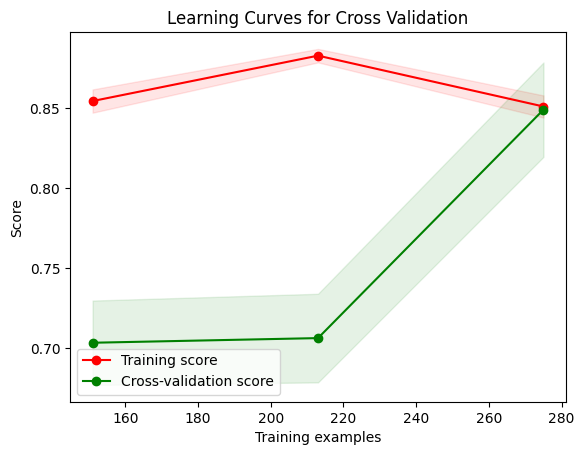

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(best_lr_balanced_scaled, X, y, train_sizes=np.linspace(.1, 1.0, 5), cv=5)

# Calculate the average and standard deviation of the training and testing scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curves for Cross Validation")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.savefig('Learning_Curves')
plt.show()


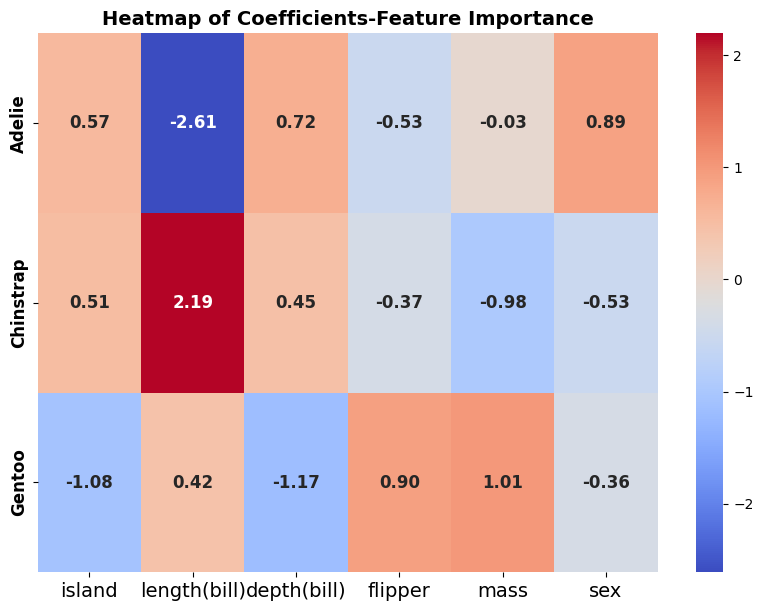

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Coefficient Heat Map
import seaborn as sns


# Coefficient Heat Map
coef = best_lr_balanced_scaled.coef_
plt.figure(figsize=(10, 7))
ax = sns.heatmap(coef, annot=True, cmap='coolwarm', fmt=".2f",
                 xticklabels=['island', 'length(bill)', 'depth(bill)', 'flipper', 'mass', 'sex'],
                 yticklabels=['Adelie', 'Chinstrap', 'Gentoo'],
                 annot_kws={'size': 12, 'weight': 'bold'},  # Change annotation size and weight
                 )

# Increase font size and weight for xticks and yticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=12, fontweight='bold')

# Increase title font size and weight
plt.title("Heatmap of Coefficients-Feature Importance", fontsize=14, fontweight='bold')
plt.savefig('feature_importance')
plt.show()

# Kmeans

# same but doing PCA as first step

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


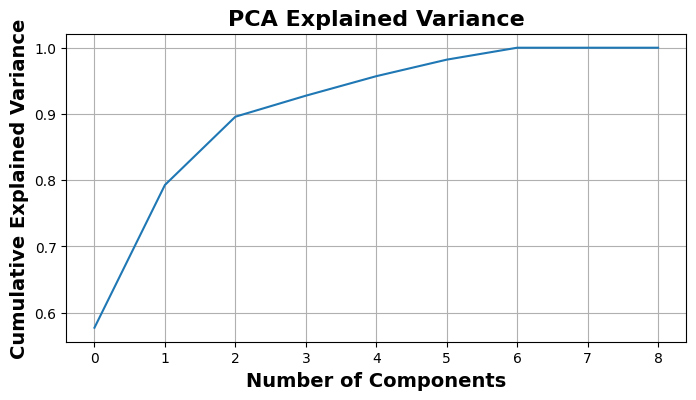

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

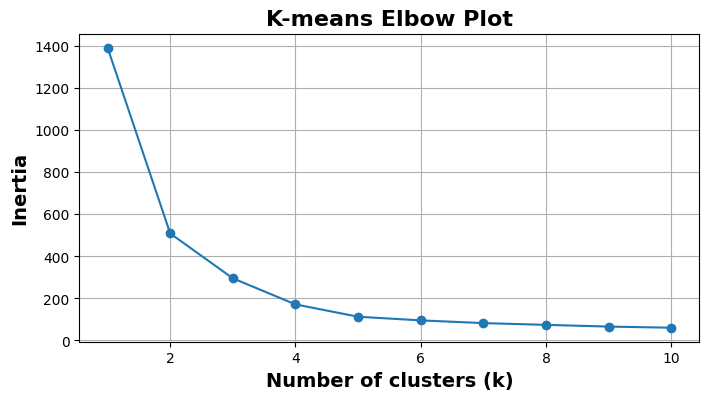

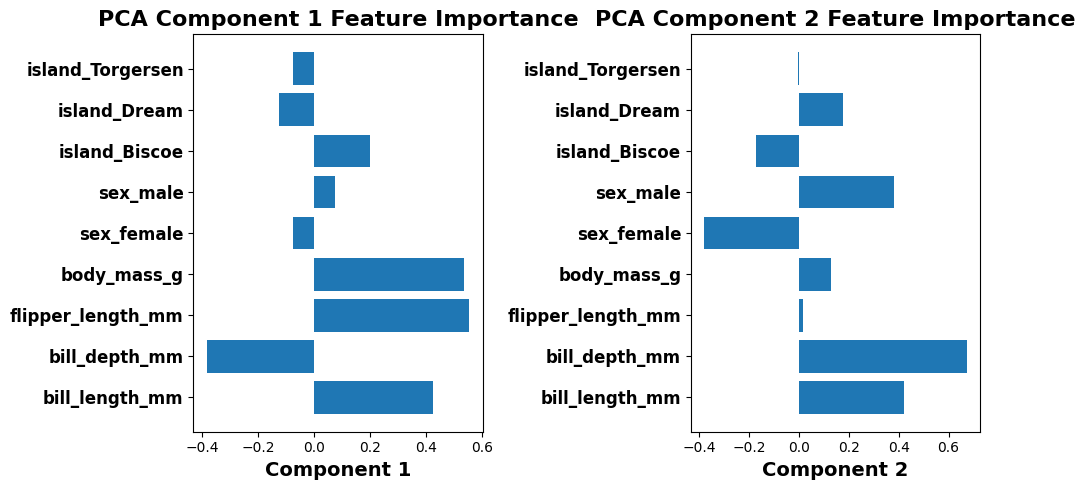

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


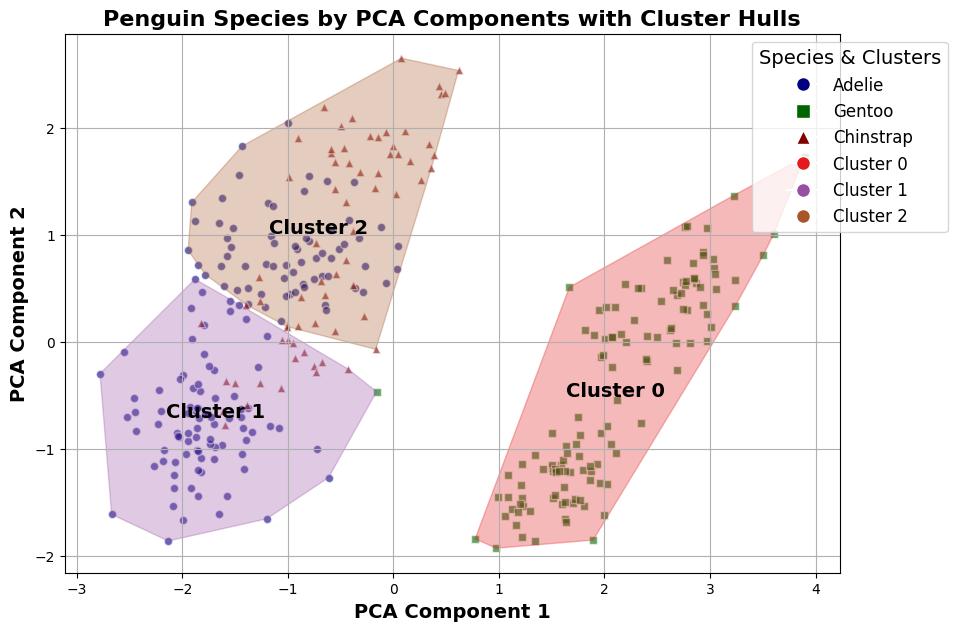

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull


# Preprocess the data
numerical_features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
categorical_features = ['sex', 'island']
data_for_clustering = penguins_data[numerical_features + categorical_features].dropna()

# Standardize numerical features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering[numerical_features])

# One-hot encode categorical features
encoder = OneHotEncoder(sparse=False)
data_encoded = encoder.fit_transform(data_for_clustering[categorical_features])

# Combine scaled numerical data with encoded categorical data
data_combined = np.hstack([data_scaled, data_encoded])

# Apply PCA
pca = PCA()
data_pca = pca.fit_transform(data_combined)

#explained variance plot
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Explained Variance', fontsize=14, fontweight='bold')
plt.title('PCA Explained Variance', fontsize=16, fontweight='bold')
plt.grid(True)
plt.savefig('explained_variance')
plt.show()



#Elbow plot
inertia_values = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_pca[:, :2])  # Using the first two principal components
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of clusters (k)', fontsize=14, fontweight='bold')
plt.ylabel('Inertia', fontsize=14, fontweight='bold')
plt.title('K-means Elbow Plot', fontsize=16, fontweight='bold')
plt.grid(True)
plt.savefig('elbow_plot')
plt.show()


# Feature Importance for PCA Components
features = numerical_features + encoder.get_feature_names_out(categorical_features).tolist()
plt.figure(figsize=(10, 5))
for i, component in enumerate(pca.components_[:2], 1):
    plt.subplot(1, 2, i)
    plt.barh(range(len(features)), component)
    plt.yticks(range(len(features)), features, fontsize=12, fontweight='bold')
    plt.xlabel(f'Component {i}', fontsize=14, fontweight='bold')
    plt.title(f'PCA Component {i} Feature Importance', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('feature_importance_PCA')
plt.show()


# Final Scatter Plot with adjusted visualization
# Specifying stronger colors and shapes for species
stronger_colors = {'Adelie': 'navy', 'Gentoo': 'darkgreen', 'Chinstrap': 'maroon'}
shapes = {'Adelie': 'o', 'Gentoo': 's', 'Chinstrap': '^'}
cluster_colors = plt.cm.Set1(np.linspace(0, 1, 4))

plt.figure(figsize=(10, 7))
# Plot points for each species
for species, color in stronger_colors.items():
    ix = penguins_data['species'] == species
    plt.scatter(data_pca[ix, 0], data_pca[ix, 1], c=color, label=species, alpha=0.6, edgecolors='w', marker=shapes[species])

# Cluster analysis and convex hulls based on first two PCA components
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data_pca[:, :2])

# Draw filled convex hulls for clusters
for i in range(3):
    points = data_pca[clusters == i, :2]
    if points.shape[0] > 2:
        hull = ConvexHull(points)
        vertices = hull.vertices
        plt.fill(points[vertices, 0], points[vertices, 1], alpha=0.3, c=cluster_colors[i], label=f'Cluster {i}')
        # Label the cluster
        cent = np.mean(points, axis=0)
        plt.text(cent[0], cent[1], f'Cluster {i}', horizontalalignment='center', verticalalignment='center', fontsize=14, fontweight='bold', color='black')

# Adjusting legend for species and clusters
legend_elements_species = [Line2D([0], [0], marker=shapes[species], color='w', label=species, markerfacecolor=color, markersize=10) for species, color in stronger_colors.items()]
legend_elements_clusters = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}', markerfacecolor=cluster_colors[i], markersize=10) for i in range(3)]
legend_elements = legend_elements_species + legend_elements_clusters

plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1), title='Species & Clusters', fontsize=12, title_fontsize=14)
plt.title('Penguin Species by PCA Components with Cluster Hulls', fontsize=16, fontweight='bold')
plt.xlabel('PCA Component 1', fontsize=14, fontweight='bold')
plt.ylabel('PCA Component 2', fontsize=14, fontweight='bold')
plt.grid(True)
plt.savefig('kmeans_clusters')
plt.show()

